In [17]:
import os
import torch
from torch import nn
import random
from PIL import Image
import glob
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as F
from torch.utils.data import ConcatDataset,DataLoader
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
current_path = os.getcwd()
print(current_path)

C:\Users\PicardiC\apziva_projects\-k9yztuWskyqtcZpB


In [4]:
train_dir = os.path.join(current_path, 'images\\training')
test_dir = os.path.join(current_path, 'images\\testing')
train_dir, test_dir

('C:\\Users\\PicardiC\\apziva_projects\\-k9yztuWskyqtcZpB\\images\\training',
 'C:\\Users\\PicardiC\\apziva_projects\\-k9yztuWskyqtcZpB\\images\\testing')

### Understanding the data

Random image path: images\training\notflip\0044_000000007.jpg
Image class: notflip
Image height: 1920
Image width: 1080


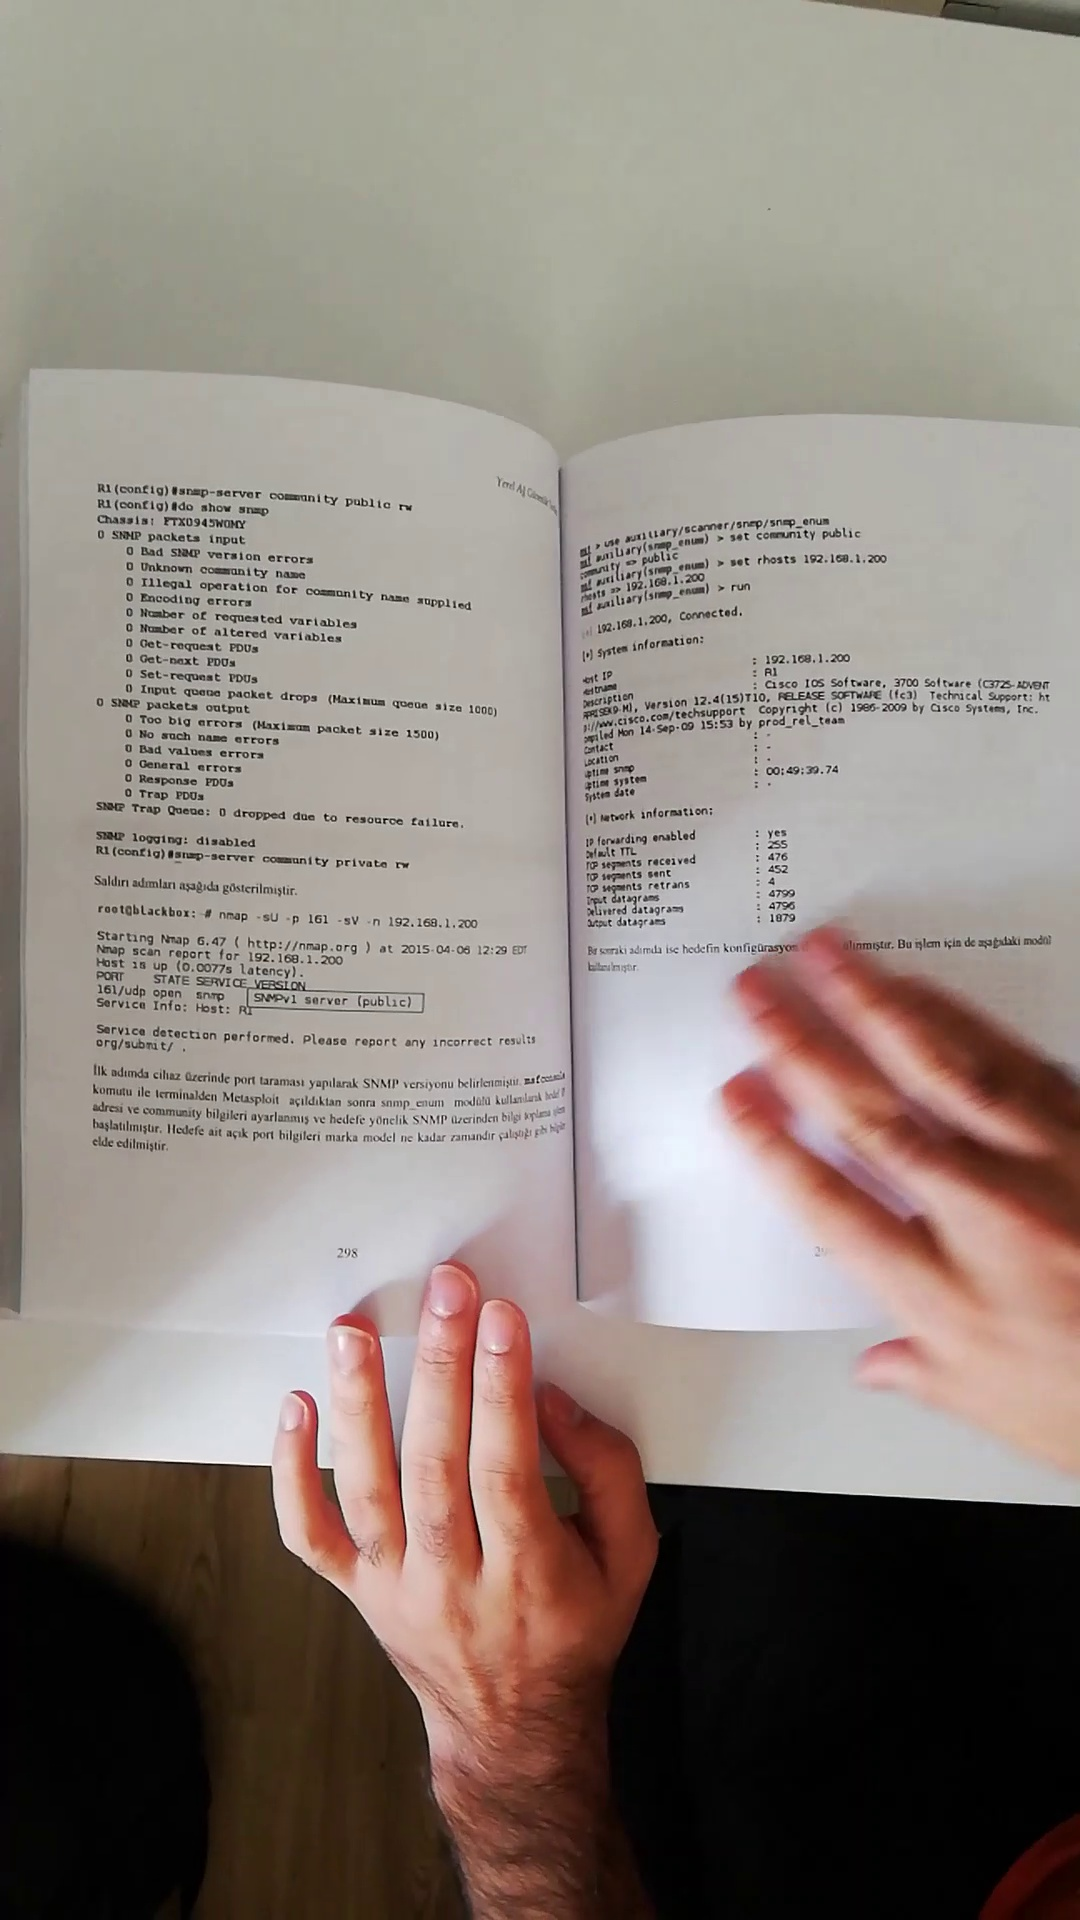

In [5]:
# Set seed
random.seed(42) 

image_path = 'images'

# 1. Get all image paths (* means "any combination")
image_path_list= glob.glob(f"{image_path}/*/*/*.jpg")

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = Path(random_image_path).parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

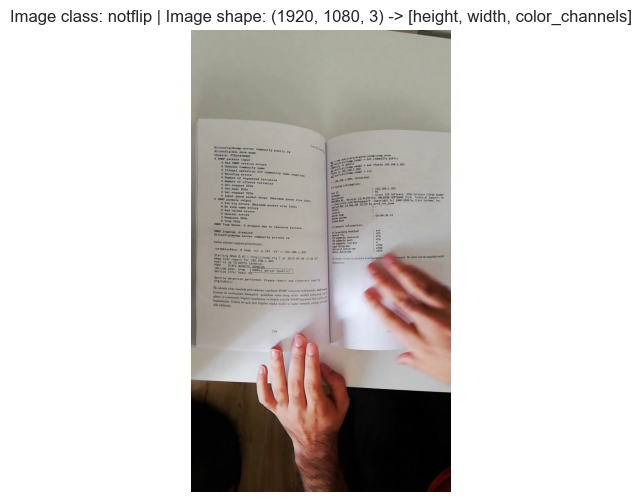

In [6]:
sns.set_theme()

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

### Image preprocessing

Custom transform resizing image while preserving aspect ratio

In [7]:
class ResizeWithAspectRatio:
    def __init__(self,desired_size):
        self.size = desired_size
    def __call__(self,image):
        #Resize an image while preserving its aspect ratio.
        old_width, old_height = image.size
        aspect_ratio = old_width / old_height

        # Calculate the new size based on the aspect ratio
        if aspect_ratio > 1:  # Landscape orientation
            new_width = self.size
            new_height = int(self.size / aspect_ratio)
            # Calculate the amount of padding required
            print(new_height)
            padding_needed = max(0, (desired_size - new_height)//2)
            # Define the padding (left, top, right, bottom)
            padding = (0, padding_needed, 0, padding_needed)
            #transform_pad = transforms.Pad((self.size - new_height) // 2, fill=0) 
        else:  # Portrait or square orientation
            new_height = self.size
            new_width = int(self.size * aspect_ratio)
            padding_needed = max(0, (desired_size - new_width)//2)
            # Define the padding (left, top, right, bottom)
            padding = (padding_needed, 0, padding_needed, 0)
            #padding = (0, padding_needed, 0, padding_needed)
            #transform_pad = transforms.Pad((self.size - new_width) // 2, fill=0)  
        
        # Resize the image
        resized_image = image.resize((new_width,new_height))
        resized_image = F.pad(resized_image, padding)
        return resized_image


In [41]:
desired_size = 224
IMAGE_WIDTH = 516
IMAGE_HEIGHT= 516
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Write transform for image
data_transform = transforms.Compose([
    ResizeWithAspectRatio(desired_size),
   # transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
   # transforms.RandomRotation(degrees=30),  # Randomly rotate the image by up to 30 degrees
#    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image with ImageNet mean and standard deviation
])
# Define transformations for data augmentation
augmentation = transforms.Compose([
    ResizeWithAspectRatio(desired_size),
    transforms.RandomRotation(degrees=10),        # Random rotation up to 10 degrees
    transforms.RandomHorizontalFlip(),           # Random horizontal flip
    transforms.ColorJitter(brightness=0.2,       # Random color jitter
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),
    transforms.RandomVerticalFlip(),             # Random vertical flip
    transforms.RandomAffine(degrees=0,           # Random affine transformation
                            translate=(0.1, 0.1),
                            scale=(0.9, 1.1),
                            shear=10),
    transforms.ToTensor(),                       # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


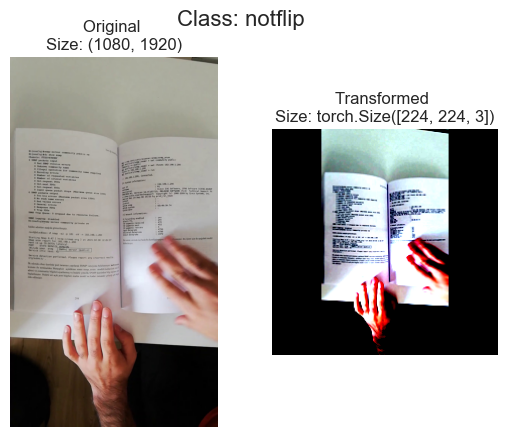

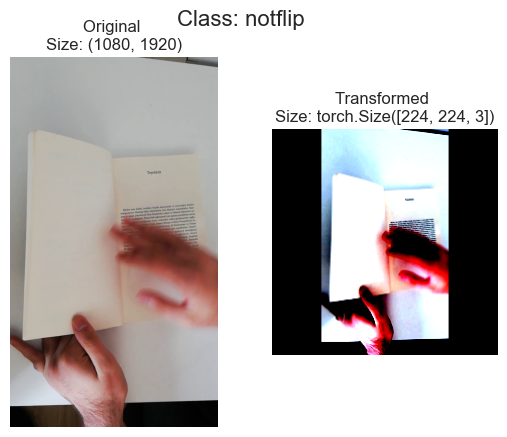

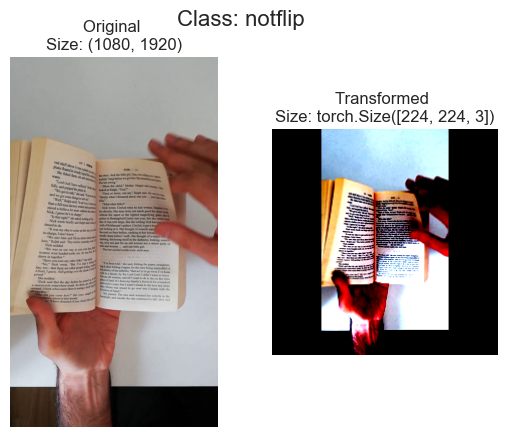

In [42]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {Path(random_image_path).parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=data_transform, n=3)



### Loading image data

In [43]:
from torchvision import datasets

# Creating training set
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)
#train_data_aug = datasets.ImageFolder(root=train_dir, # target folder of images
#                                  transform=augmentation, # transforms to perform on data (images)
#                                  target_transform=None) # transforms to perform on labels (if necessary)
## Concatenate original and augmented datasets
#train_data = torch.utils.data.ConcatDataset([train_data, train_data_aug])

#Creating test set
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 2392
    Root location: C:\Users\PicardiC\apziva_projects\-k9yztuWskyqtcZpB\images\training
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 597
    Root location: C:\Users\PicardiC\apziva_projects\-k9yztuWskyqtcZpB\images\testing
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [44]:
# Get class names as a list
class_names = train_data.classes
print("Class names: ",class_names)

# Can also get class names as a dict
class_dict = train_data.class_to_idx
print("Class names as a dict: ",class_dict)

# Check the lengths
print("The lengths of the training and test sets: ", len(train_data), len(test_data))


Class names:  ['flip', 'notflip']
Class names as a dict:  {'flip': 0, 'notflip': 1}
The lengths of the training and test sets:  2392 597


Create DataLoader for training

In [45]:
# How many subprocesses will be used for data loading (higher = more)
NUM_WORKERS = 4 if torch.cuda.is_available() else 0 

# Turn train and test Datasets into DataLoaders
train_loader = DataLoader(dataset=train_data, 
                              batch_size=32, # how many samples per batch?
                              num_workers=NUM_WORKERS,
                              shuffle=True) # shuffle the data?

test_loader = DataLoader(dataset=test_data, 
                             batch_size=32, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False) # don't usually need to shuffle testing data

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x1e1d851a290>,
 <torch.utils.data.dataloader.DataLoader at 0x1e1d853f650>)

### Using MobileNet

In [46]:
# Load the pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# Freeze the parameters so we don't backpropagate through them
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier to fit the number of classes in our dataset
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 2)

C:\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False, dynamic_ncols=True)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        pbar.set_postfix({'Loss': running_loss / len(train_loader.dataset)})
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
# Evaluate the model
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
print(f"Number of true positive: {tp}, number of false negative:{fn}, number of true negatives: {tn}, number of false positive {fp}.")


# Compute F1 score
f1 = f1_score(true_labels, predicted_labels, average='macro')
print("F1 Score:", f1)
accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10, Loss: 0.5169


Epoch 2/10, Loss: 0.3602


Epoch 3/10, Loss: 0.3504


Epoch 4/10, Loss: 0.3014


Epoch 5/10, Loss: 0.2703


Epoch 6/10, Loss: 0.2244


Epoch 7/10, Loss: 0.2393


Epoch 8/10, Loss: 0.2369


Epoch 9/10, Loss: 0.2033


Epoch 10/10, Loss: 0.1965
Confusion Matrix:
[[266  24]
 [  6 301]]
Number of true positive: 301, number of false negative:6, number of true negatives: 266, number of false positive 24.
F1 Score: 0.9495754313257354
Test Accuracy: 0.9497
